In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read data
data = pd.read_csv("conglomerated-all.csv")
data.columns

Index(['Date', 'Client_Future Index Long', 'Client_Future Index Short',
       'Client_Option Index Call Long', 'Client_Option Index Put Long',
       'Client_Option Index Call Short', 'Client_Option Index Put Short',
       'DII_Future Index Long', 'DII_Future Index Short',
       'DII_Option Index Call Long', 'DII_Option Index Put Long',
       'DII_Option Index Call Short', 'DII_Option Index Put Short',
       'FII_Future Index Long', 'FII_Future Index Short',
       'FII_Option Index Call Long', 'FII_Option Index Put Long',
       'FII_Option Index Call Short', 'FII_Option Index Put Short',
       'Total Call Options - Open Interest BANK NIFTY INDEX',
       'Total Put Options - Open Interest BANK NIFTY INDEX',
       'Total Futures - Open Interest BANK NIFTY INDEX',
       'Price - BANK NIFTY INDEX', 'Returns - BANK NIFTY INDEX',
       'NSE VIX - India', 'is_expiry', 'Total_OI'],
      dtype='object')

In [2]:
# Add day of week column
data["DayOfWeek"] = pd.to_datetime(data["Date"]).dt.dayofweek

In [3]:
import statsmodels.api as sm

# Calculate total Client OI (sum of all client positions)
data['Client_Total_OI'] = (
    data['Client_Future Index Long'] + data['Client_Future Index Short'] +
    data['Client_Option Index Call Long'] + data['Client_Option Index Put Long'] +
    data['Client_Option Index Call Short'] + data['Client_Option Index Put Short']
)

# Y1: Retail Share
data['Retail_Share'] = (data['Client_Total_OI'] / data['Total_OI']) * 100

# Y2: Retail Short Ratio
data['Client_Short_OI'] = (
    data['Client_Future Index Short'] +
    data['Client_Option Index Call Short'] +
    data['Client_Option Index Put Short']
)
data['Retail_Short_Ratio'] = data['Client_Short_OI'] / data['Client_Total_OI']

# Y3: Retail Put Share
data['Client_Put_OI'] = data['Client_Option Index Put Long'] + data['Client_Option Index Put Short']
data['Client_Call_OI'] = data['Client_Option Index Call Long'] + data['Client_Option Index Call Short']
data['Retail_Put_Share'] = data['Client_Put_OI'] / (data['Client_Put_OI'] + data['Client_Call_OI'])

# Prepare independent variables
X = data[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX']].copy()
X = sm.add_constant(X)  # Adds the constant term (α)

regression_data = pd.concat([X, data[['Retail_Share', 'Retail_Short_Ratio', 'Retail_Put_Share']]], axis=1)
regression_data = regression_data.dropna()
# Update X and Y variables after dropping NaNs
X_clean = regression_data[['const', 'DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX']]

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

regression_cols = ['Date', 'DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                   'Retail_Share', 'Retail_Short_Ratio', 'Retail_Put_Share', 'is_expiry']

clean_data = data[regression_cols].copy()

# Replace infinite values with NaN
clean_data = clean_data.replace([np.inf, -np.inf], np.nan)

# Drop rows with any missing values
clean_data = clean_data.dropna()


In [5]:
# FII Net Position (smart money indicator)
clean_data['FII_Net_Position'] = (
    data['FII_Future Index Long'] - data['FII_Future Index Short'] +
    data['FII_Option Index Call Long'] - data['FII_Option Index Call Short'] +
    data['FII_Option Index Put Short'] - data['FII_Option Index Put Long']
)

# FII Share of total OI (institutional dominance)
clean_data['FII_Share'] = (
    (data['FII_Future Index Long'] + data['FII_Future Index Short'] +
     data['FII_Option Index Call Long'] + data['FII_Option Index Put Long'] +
     data['FII_Option Index Call Short'] + data['FII_Option Index Put Short']) /
    data['Total_OI']
) * 100


# Lagged returns (momentum/reversal effects)
clean_data['Returns_Lag1'] = data['Returns - BANK NIFTY INDEX'].shift(1)
clean_data['Returns_Lag2'] = data['Returns - BANK NIFTY INDEX'].shift(2)
clean_data['Returns_Lag5'] = data['Returns - BANK NIFTY INDEX'].shift(5)  # weekly

# Cumulative returns (recent performance)
clean_data['Returns_5day'] = data['Returns - BANK NIFTY INDEX'].rolling(5).sum()
clean_data['Returns_20day'] = data['Returns - BANK NIFTY INDEX'].rolling(20).sum()

# Lagged volatility
clean_data['VIX_Lag1'] = data['NSE VIX - India'].shift(1)
clean_data['VIX_Lag5'] = data['NSE VIX - India'].shift(5)

# Change in VIX (volatility shock indicator)
clean_data['VIX_Change'] = data['NSE VIX - India'].diff()
clean_data['VIX_Spike'] = (clean_data['VIX_Change'] > clean_data['VIX_Change'].quantile(0.75)).astype(int)

# High vs low volatility regime
clean_data['High_VIX_Regime'] = (data['NSE VIX - India'] > data['NSE VIX - India'].median()).astype(int)

# Bull vs bear market
clean_data['Bull_Market'] = (clean_data['Returns_20day'] > 0).astype(int)

# Winning vs losing days
clean_data['Positive_Return'] = (data['Returns - BANK NIFTY INDEX'] > 0).astype(int)

# Market stress indicator (high VIX + negative returns)
clean_data['Market_Stress'] = ((data['NSE VIX - India'] > data['NSE VIX - India'].quantile(0.75)) & 
                                (data['Returns - BANK NIFTY INDEX'] < 0)).astype(int)

# Historical volatility (standard deviation of returns)
clean_data['Realized_Vol_5d'] = data['Returns - BANK NIFTY INDEX'].rolling(5).std() * np.sqrt(252)
clean_data['Realized_Vol_20d'] = data['Returns - BANK NIFTY INDEX'].rolling(20).std() * np.sqrt(252)

# Range-based volatility
clean_data['Daily_Range'] = ((data['Price - BANK NIFTY INDEX'].rolling(2).max() - 
                              data['Price - BANK NIFTY INDEX'].rolling(2).min()) / 
                             data['Price - BANK NIFTY INDEX']) * 100

# Days until next expiry (if you can calculate this)
# Bank Nifty options expire weekly on Wednesdays
clean_data['Days_To_Expiry'] = clean_data['DayOfWeek'].apply(
    lambda x: (2 - x) % 7 if x <= 2 else (9 - x)  # 0=Mon, 2=Wed expiry
)

# Week of expiry indicator
clean_data['Expiry_Week'] = (clean_data['Days_To_Expiry'] <= 2).astype(int)

# Model 1: Add institutional positioning
X1 = clean_data[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX', 
                 'FII_Net_Position']]

# Model 2: Add lagged effects
X2 = clean_data[['DayOfWeek', 'NSE VIX - India', 'Returns_Lag1', 'VIX_Lag1']]

# Model 3: Add market stress
X3 = clean_data[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                 'Market_Stress', 'VIX_Spike']]

# Model 4: Add expiry dynamics
X4 = clean_data[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                 'Days_To_Expiry', 'is_expiry']]

# Model 5: Comprehensive model
X5 = clean_data[['DayOfWeek', 'NSE VIX - India', 'Returns_Lag1', 
                 'FII_Net_Position', 'Market_Stress', 'Days_To_Expiry']]

In [6]:
from sklearn.preprocessing import StandardScaler

# Standardize all continuous variables to mean=0, std=1
scaler = StandardScaler()
vars_to_scale = ['NSE VIX - India', 'Returns - BANK NIFTY INDEX', 'FII_Net_Position']

clean_data_scaled = clean_data.copy()
clean_data_scaled[vars_to_scale] = scaler.fit_transform(clean_data[vars_to_scale])

# Run regression with scaled variables
X1_scaled = clean_data_scaled[['DayOfWeek', 'NSE VIX - India', 
                                'Returns - BANK NIFTY INDEX', 'FII_Net_Position']]
X1_scaled = sm.add_constant(X1_scaled)

model_scaled_Retail_Share_X1 = sm.OLS(clean_data_scaled['Retail_Share'], X1_scaled).fit()
print(model_scaled_Retail_Share_X1.summary())

                            OLS Regression Results                            
Dep. Variable:           Retail_Share   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     25.44
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           1.06e-16
Time:                        00:55:00   Log-Likelihood:                -391.44
No. Observations:                 184   AIC:                             792.9
Df Residuals:                     179   BIC:                             809.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [7]:
model_scaled_Retail_Short_X1 = sm.OLS(clean_data_scaled['Retail_Short_Ratio'], X1_scaled).fit()
print(model_scaled_Retail_Short_X1.summary())

                            OLS Regression Results                            
Dep. Variable:     Retail_Short_Ratio   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     7.732
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           9.06e-06
Time:                        00:55:00   Log-Likelihood:                 580.53
No. Observations:                 184   AIC:                            -1151.
Df Residuals:                     179   BIC:                            -1135.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [8]:
model_scaled_Retail_Put_X1 = sm.OLS(clean_data_scaled['Retail_Put_Share'], X1_scaled).fit()
print(model_scaled_Retail_Put_X1.summary())

                            OLS Regression Results                            
Dep. Variable:       Retail_Put_Share   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     5.172
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           0.000576
Time:                        00:55:00   Log-Likelihood:                 311.03
No. Observations:                 184   AIC:                            -612.1
Df Residuals:                     179   BIC:                            -596.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [9]:
scaler_X2 = StandardScaler()
vars_to_scale_X2 = ['NSE VIX - India', 'Returns_Lag1', 'VIX_Lag1']

clean_data_scaled_X2 = clean_data.copy()

# Drop NaN/inf values first
regression_cols_X2 = ['DayOfWeek', 'NSE VIX - India', 'Returns_Lag1', 'VIX_Lag1',
                       'Retail_Share', 'Retail_Short_Ratio', 'Retail_Put_Share']
clean_data_scaled_X2 = clean_data_scaled_X2[regression_cols_X2].replace([np.inf, -np.inf], np.nan).dropna()

# Scale the continuous variables
clean_data_scaled_X2[vars_to_scale_X2] = scaler_X2.fit_transform(clean_data_scaled_X2[vars_to_scale_X2])

# Run regression with scaled variables
X2_scaled = clean_data_scaled_X2[['DayOfWeek', 'NSE VIX - India', 'Returns_Lag1', 'VIX_Lag1']]
X2_scaled = sm.add_constant(X2_scaled)

model_scaled_Retail_Share_X2 = sm.OLS(clean_data_scaled_X2['Retail_Share'], X2_scaled).fit()
model_scaled_Retail_Short_X2 = sm.OLS(clean_data_scaled_X2['Retail_Short_Ratio'], X2_scaled).fit()
model_scaled_Retail_Put_X2 = sm.OLS(clean_data_scaled_X2['Retail_Put_Share'], X2_scaled).fit()

In [10]:
scaler_X3 = StandardScaler()
vars_to_scale_X3 = ['NSE VIX - India', 'Returns - BANK NIFTY INDEX']

clean_data_scaled_X3 = clean_data.copy()

# Drop NaN/inf values first
regression_cols_X3 = ['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                       'Market_Stress', 'VIX_Spike',
                       'Retail_Share', 'Retail_Short_Ratio', 'Retail_Put_Share']
clean_data_scaled_X3 = clean_data_scaled_X3[regression_cols_X3].replace([np.inf, -np.inf], np.nan).dropna()

# Scale the continuous variables
clean_data_scaled_X3[vars_to_scale_X3] = scaler_X3.fit_transform(clean_data_scaled_X3[vars_to_scale_X3])

# Run regression with scaled variables
X3_scaled = clean_data_scaled_X3[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                                   'Market_Stress', 'VIX_Spike']]
X3_scaled = sm.add_constant(X3_scaled)

model_scaled_Retail_Share_X3 = sm.OLS(clean_data_scaled_X3['Retail_Share'], X3_scaled).fit()
model_scaled_Retail_Short_X3 = sm.OLS(clean_data_scaled_X3['Retail_Short_Ratio'], X3_scaled).fit()
model_scaled_Retail_Put_X3 = sm.OLS(clean_data_scaled_X3['Retail_Put_Share'], X3_scaled).fit()


In [11]:
scaler_X4 = StandardScaler()
vars_to_scale_X4 = ['NSE VIX - India', 'Returns - BANK NIFTY INDEX']

clean_data_scaled_X4 = clean_data.copy()

# Drop NaN/inf values first
regression_cols_X4 = ['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                       'Days_To_Expiry', 'is_expiry',
                       'Retail_Share', 'Retail_Short_Ratio', 'Retail_Put_Share']
clean_data_scaled_X4 = clean_data_scaled_X4[regression_cols_X4].replace([np.inf, -np.inf], np.nan).dropna()

# Scale the continuous variables
clean_data_scaled_X4[vars_to_scale_X4] = scaler_X4.fit_transform(clean_data_scaled_X4[vars_to_scale_X4])

# Run regression with scaled variables
X4_scaled = clean_data_scaled_X4[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                                   'Days_To_Expiry', 'is_expiry']]
X4_scaled = sm.add_constant(X4_scaled)

model_scaled_Retail_Share_X4 = sm.OLS(clean_data_scaled_X4['Retail_Share'], X4_scaled).fit()
model_scaled_Retail_Short_X4 = sm.OLS(clean_data_scaled_X4['Retail_Short_Ratio'], X4_scaled).fit()
model_scaled_Retail_Put_X4 = sm.OLS(clean_data_scaled_X4['Retail_Put_Share'], X4_scaled).fit()


In [12]:
scaler_X5 = StandardScaler()
vars_to_scale_X5 = ['NSE VIX - India', 'Returns_Lag1', 'FII_Net_Position']

clean_data_scaled_X5 = clean_data.copy()

# Drop NaN/inf values first
regression_cols_X5 = ['DayOfWeek', 'NSE VIX - India', 'Returns_Lag1',
                       'FII_Net_Position', 'Market_Stress', 'Days_To_Expiry',
                       'Retail_Share', 'Retail_Short_Ratio', 'Retail_Put_Share']
clean_data_scaled_X5 = clean_data_scaled_X5[regression_cols_X5].replace([np.inf, -np.inf], np.nan).dropna()

# Scale the continuous variables
clean_data_scaled_X5[vars_to_scale_X5] = scaler_X5.fit_transform(clean_data_scaled_X5[vars_to_scale_X5])

# Run regression with scaled variables
X5_scaled = clean_data_scaled_X5[['DayOfWeek', 'NSE VIX - India', 'Returns_Lag1',
                                   'FII_Net_Position', 'Market_Stress', 'Days_To_Expiry']]
X5_scaled = sm.add_constant(X5_scaled)

model_scaled_Retail_Share_X5 = sm.OLS(clean_data_scaled_X5['Retail_Share'], X5_scaled).fit()
model_scaled_Retail_Short_X5 = sm.OLS(clean_data_scaled_X5['Retail_Short_Ratio'], X5_scaled).fit()
model_scaled_Retail_Put_X5 = sm.OLS(clean_data_scaled_X5['Retail_Put_Share'], X5_scaled).fit()


In [13]:
def extract_model_results(model, model_name, dependent_var):
    """
    Extract all key statistics from an OLS model into a dictionary.
    """
    results_dict = {
        'Model': model_name,
        'Dependent_Variable': dependent_var,
        'R_squared': model.rsquared,
        'Adj_R_squared': model.rsquared_adj,
        'F_statistic': model.fvalue,
        'F_pvalue': model.f_pvalue,
        'AIC': model.aic,
        'BIC': model.bic,
        'N_observations': int(model.nobs),
        'Num_variables': len(model.params) - 1  # Exclude constant
    }
    
    # Add coefficients and p-values for each variable
    for var in model.params.index:
        if var != 'const':
            results_dict[f'{var}_coef'] = model.params[var]
            results_dict[f'{var}_pvalue'] = model.pvalues[var]
            results_dict[f'{var}_significant'] = 'Yes' if model.pvalues[var] < 0.05 else 'No'
    
    return results_dict


In [14]:
models_config = [
    # X1: Institutional
    (model_scaled_Retail_Share_X1, 'X1: Institutional', 'Retail_Share'),
    (model_scaled_Retail_Short_X1, 'X1: Institutional', 'Retail_Short_Ratio'),
    (model_scaled_Retail_Put_X1, 'X1: Institutional', 'Retail_Put_Share'),
    
    # X2: Lagged Effects
    (model_scaled_Retail_Share_X2, 'X2: Lagged Effects', 'Retail_Share'),
    (model_scaled_Retail_Short_X2, 'X2: Lagged Effects', 'Retail_Short_Ratio'),
    (model_scaled_Retail_Put_X2, 'X2: Lagged Effects', 'Retail_Put_Share'),
    
    # X3: Market Stress
    (model_scaled_Retail_Share_X3, 'X3: Market Stress', 'Retail_Share'),
    (model_scaled_Retail_Short_X3, 'X3: Market Stress', 'Retail_Short_Ratio'),
    (model_scaled_Retail_Put_X3, 'X3: Market Stress', 'Retail_Put_Share'),
    
    # X4: Expiry Dynamics
    (model_scaled_Retail_Share_X4, 'X4: Expiry Dynamics', 'Retail_Share'),
    (model_scaled_Retail_Short_X4, 'X4: Expiry Dynamics', 'Retail_Short_Ratio'),
    (model_scaled_Retail_Put_X4, 'X4: Expiry Dynamics', 'Retail_Put_Share'),
    
    # X5: Comprehensive
    (model_scaled_Retail_Share_X5, 'X5: Comprehensive', 'Retail_Share'),
    (model_scaled_Retail_Short_X5, 'X5: Comprehensive', 'Retail_Short_Ratio'),
    (model_scaled_Retail_Put_X5, 'X5: Comprehensive', 'Retail_Put_Share'),
]


In [15]:
all_results = []

for model, model_name, dep_var in models_config:
    all_results.append(extract_model_results(model, model_name, dep_var))

# Convert to DataFrame
all_results_df = pd.DataFrame(all_results)

In [16]:
detailed_results = []

for model, model_name, dep_var in models_config:
    for var in model.params.index:
        if var != 'const':
            detailed_results.append({
                'Model': model_name,
                'Dependent_Variable': dep_var,
                'Independent_Variable': var,
                'Coefficient': model.params[var],
                'Std_Error': model.bse[var],
                't_value': model.tvalues[var],
                'p_value': model.pvalues[var],
                'CI_Lower': model.conf_int().loc[var, 0],
                'CI_Upper': model.conf_int().loc[var, 1],
                'Significant_5%': 'Yes' if model.pvalues[var] < 0.05 else 'No',
                'Significant_10%': 'Yes' if model.pvalues[var] < 0.10 else 'No',
                'Is this model significant overall (F-test p<0.05)?': 'Yes' if model.f_pvalue < 0.05 else 'No'
            })

detailed_df = pd.DataFrame(detailed_results)
significant_df = detailed_df[detailed_df['Significant_5%'] == 'Yes']
detailed_df.to_csv('all_coefficients_detailed_X1_X5.csv', index=False)

In [17]:
# Calculate Bank Nifty specific dependent variables
data['Bank_Nifty_Total_OI'] = (
    data['Total Call Options - Open Interest BANK NIFTY INDEX'] + 
    data['Total Put Options - Open Interest BANK NIFTY INDEX'] + 
    data['Total Futures - Open Interest BANK NIFTY INDEX']
)

data['BN_Market_Weight'] = data['Bank_Nifty_Total_OI'] / data['Total_OI']

data['Retail_BN_Total_OI_Est'] = data['Client_Total_OI'] * data['BN_Market_Weight']
data['Retail_BN_Short_OI_Est'] = data['Client_Short_OI'] * data['BN_Market_Weight']
data['Retail_BN_Put_OI_Est'] = data['Client_Put_OI'] * data['BN_Market_Weight']
data['Retail_BN_Call_OI_Est'] = data['Client_Call_OI'] * data['BN_Market_Weight']

# Y1: Retail Share in Bank Nifty
data['Retail_Share_BN'] = (data['Retail_BN_Total_OI_Est'] / data['Bank_Nifty_Total_OI']) * 100

# Y2: Retail Short Ratio in Bank Nifty
data['Retail_Short_Ratio_BN'] = data['Retail_BN_Short_OI_Est'] / data['Retail_BN_Total_OI_Est']

# Y3: Retail Put Share in Bank Nifty
data['Retail_Put_Share_BN'] = data['Retail_BN_Put_OI_Est'] / (data['Retail_BN_Put_OI_Est'] + data['Retail_BN_Call_OI_Est'])

In [18]:
regression_cols_BN = ['Date', 'DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                       'Retail_Share_BN', 'Retail_Short_Ratio_BN', 'Retail_Put_Share_BN', 'is_expiry']

clean_data_BN = data[regression_cols_BN].copy()

clean_data_BN = clean_data_BN.replace([np.inf, -np.inf], np.nan)

clean_data_BN = clean_data_BN.dropna()

In [19]:
# FII Net Position
clean_data_BN['FII_Net_Position'] = (
    data['FII_Future Index Long'] - data['FII_Future Index Short'] +
    data['FII_Option Index Call Long'] - data['FII_Option Index Call Short'] +
    data['FII_Option Index Put Short'] - data['FII_Option Index Put Long']
)

# FII Share
clean_data_BN['FII_Share'] = (
    (data['FII_Future Index Long'] + data['FII_Future Index Short'] +
     data['FII_Option Index Call Long'] + data['FII_Option Index Put Long'] +
     data['FII_Option Index Call Short'] + data['FII_Option Index Put Short']) /
    data['Total_OI']
) * 100

# Lagged returns
clean_data_BN['Returns_Lag1'] = data['Returns - BANK NIFTY INDEX'].shift(1)
clean_data_BN['Returns_Lag2'] = data['Returns - BANK NIFTY INDEX'].shift(2)
clean_data_BN['Returns_Lag5'] = data['Returns - BANK NIFTY INDEX'].shift(5)

# Cumulative returns
clean_data_BN['Returns_5day'] = data['Returns - BANK NIFTY INDEX'].rolling(5).sum()
clean_data_BN['Returns_20day'] = data['Returns - BANK NIFTY INDEX'].rolling(20).sum()

# Lagged volatility
clean_data_BN['VIX_Lag1'] = data['NSE VIX - India'].shift(1)
clean_data_BN['VIX_Lag5'] = data['NSE VIX - India'].shift(5)

# Change in VIX
clean_data_BN['VIX_Change'] = data['NSE VIX - India'].diff()
clean_data_BN['VIX_Spike'] = (clean_data_BN['VIX_Change'] > clean_data_BN['VIX_Change'].quantile(0.75)).astype(int)

# High vs low volatility regime
clean_data_BN['High_VIX_Regime'] = (data['NSE VIX - India'] > data['NSE VIX - India'].median()).astype(int)

# Bull vs bear market
clean_data_BN['Bull_Market'] = (clean_data_BN['Returns_20day'] > 0).astype(int)

# Winning vs losing days
clean_data_BN['Positive_Return'] = (data['Returns - BANK NIFTY INDEX'] > 0).astype(int)

# Market stress indicator
clean_data_BN['Market_Stress'] = ((data['NSE VIX - India'] > data['NSE VIX - India'].quantile(0.75)) & 
                                   (data['Returns - BANK NIFTY INDEX'] < 0)).astype(int)

# Historical volatility
clean_data_BN['Realized_Vol_5d'] = data['Returns - BANK NIFTY INDEX'].rolling(5).std() * np.sqrt(252)
clean_data_BN['Realized_Vol_20d'] = data['Returns - BANK NIFTY INDEX'].rolling(20).std() * np.sqrt(252)

# Range-based volatility
clean_data_BN['Daily_Range'] = ((data['Price - BANK NIFTY INDEX'].rolling(2).max() - 
                                  data['Price - BANK NIFTY INDEX'].rolling(2).min()) / 
                                 data['Price - BANK NIFTY INDEX']) * 100

# Days until next expiry
clean_data_BN['Days_To_Expiry'] = clean_data_BN['DayOfWeek'].apply(
    lambda x: (2 - x) % 7 if x <= 2 else (9 - x)
)

# Week of expiry indicator
clean_data_BN['Expiry_Week'] = (clean_data_BN['Days_To_Expiry'] <= 2).astype(int)

# Model 1: Add institutional positioning
X1_BN = clean_data_BN[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX', 
                        'FII_Net_Position']]

# Model 2: Add lagged effects
X2_BN = clean_data_BN[['DayOfWeek', 'NSE VIX - India', 'Returns_Lag1', 'VIX_Lag1']]

# Model 3: Add market stress
X3_BN = clean_data_BN[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                        'Market_Stress', 'VIX_Spike']]

# Model 4: Add expiry dynamics
X4_BN = clean_data_BN[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                        'Days_To_Expiry', 'is_expiry']]

# Model 5: Comprehensive model
X5_BN = clean_data_BN[['DayOfWeek', 'NSE VIX - India', 'Returns_Lag1', 
                        'FII_Net_Position', 'Market_Stress', 'Days_To_Expiry']]

In [20]:
from sklearn.preprocessing import StandardScaler

scaler_X1_BN = StandardScaler()
vars_to_scale_X1_BN = ['NSE VIX - India', 'Returns - BANK NIFTY INDEX', 'FII_Net_Position']

clean_data_scaled_X1_BN = clean_data_BN.copy()

regression_cols_X1_BN = ['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX', 'FII_Net_Position',
                          'Retail_Share_BN', 'Retail_Short_Ratio_BN', 'Retail_Put_Share_BN']
clean_data_scaled_X1_BN = clean_data_scaled_X1_BN[regression_cols_X1_BN].replace([np.inf, -np.inf], np.nan).dropna()

clean_data_scaled_X1_BN[vars_to_scale_X1_BN] = scaler_X1_BN.fit_transform(clean_data_scaled_X1_BN[vars_to_scale_X1_BN])

X1_scaled_BN = clean_data_scaled_X1_BN[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX', 'FII_Net_Position']]
X1_scaled_BN = sm.add_constant(X1_scaled_BN)

model_scaled_Retail_Share_X1_BN = sm.OLS(clean_data_scaled_X1_BN['Retail_Share_BN'], X1_scaled_BN).fit()
model_scaled_Retail_Short_X1_BN = sm.OLS(clean_data_scaled_X1_BN['Retail_Short_Ratio_BN'], X1_scaled_BN).fit()
model_scaled_Retail_Put_X1_BN = sm.OLS(clean_data_scaled_X1_BN['Retail_Put_Share_BN'], X1_scaled_BN).fit()

In [21]:
scaler_X2_BN = StandardScaler()
vars_to_scale_X2_BN = ['NSE VIX - India', 'Returns_Lag1', 'VIX_Lag1']

clean_data_scaled_X2_BN = clean_data_BN.copy()

regression_cols_X2_BN = ['DayOfWeek', 'NSE VIX - India', 'Returns_Lag1', 'VIX_Lag1',
                          'Retail_Share_BN', 'Retail_Short_Ratio_BN', 'Retail_Put_Share_BN']
clean_data_scaled_X2_BN = clean_data_scaled_X2_BN[regression_cols_X2_BN].replace([np.inf, -np.inf], np.nan).dropna()

clean_data_scaled_X2_BN[vars_to_scale_X2_BN] = scaler_X2_BN.fit_transform(clean_data_scaled_X2_BN[vars_to_scale_X2_BN])

X2_scaled_BN = clean_data_scaled_X2_BN[['DayOfWeek', 'NSE VIX - India', 'Returns_Lag1', 'VIX_Lag1']]
X2_scaled_BN = sm.add_constant(X2_scaled_BN)

model_scaled_Retail_Share_X2_BN = sm.OLS(clean_data_scaled_X2_BN['Retail_Share_BN'], X2_scaled_BN).fit()
model_scaled_Retail_Short_X2_BN = sm.OLS(clean_data_scaled_X2_BN['Retail_Short_Ratio_BN'], X2_scaled_BN).fit()
model_scaled_Retail_Put_X2_BN = sm.OLS(clean_data_scaled_X2_BN['Retail_Put_Share_BN'], X2_scaled_BN).fit()

In [22]:
scaler_X3_BN = StandardScaler()
vars_to_scale_X3_BN = ['NSE VIX - India', 'Returns - BANK NIFTY INDEX']

clean_data_scaled_X3_BN = clean_data_BN.copy()

regression_cols_X3_BN = ['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                          'Market_Stress', 'VIX_Spike',
                          'Retail_Share_BN', 'Retail_Short_Ratio_BN', 'Retail_Put_Share_BN']
clean_data_scaled_X3_BN = clean_data_scaled_X3_BN[regression_cols_X3_BN].replace([np.inf, -np.inf], np.nan).dropna()

clean_data_scaled_X3_BN[vars_to_scale_X3_BN] = scaler_X3_BN.fit_transform(clean_data_scaled_X3_BN[vars_to_scale_X3_BN])

X3_scaled_BN = clean_data_scaled_X3_BN[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                                         'Market_Stress', 'VIX_Spike']]
X3_scaled_BN = sm.add_constant(X3_scaled_BN)

model_scaled_Retail_Share_X3_BN = sm.OLS(clean_data_scaled_X3_BN['Retail_Share_BN'], X3_scaled_BN).fit()
model_scaled_Retail_Short_X3_BN = sm.OLS(clean_data_scaled_X3_BN['Retail_Short_Ratio_BN'], X3_scaled_BN).fit()
model_scaled_Retail_Put_X3_BN = sm.OLS(clean_data_scaled_X3_BN['Retail_Put_Share_BN'], X3_scaled_BN).fit()

In [23]:
scaler_X4_BN = StandardScaler()
vars_to_scale_X4_BN = ['NSE VIX - India', 'Returns - BANK NIFTY INDEX']

clean_data_scaled_X4_BN = clean_data_BN.copy()

regression_cols_X4_BN = ['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                          'Days_To_Expiry', 'is_expiry',
                          'Retail_Share_BN', 'Retail_Short_Ratio_BN', 'Retail_Put_Share_BN']
clean_data_scaled_X4_BN = clean_data_scaled_X4_BN[regression_cols_X4_BN].replace([np.inf, -np.inf], np.nan).dropna()

clean_data_scaled_X4_BN[vars_to_scale_X4_BN] = scaler_X4_BN.fit_transform(clean_data_scaled_X4_BN[vars_to_scale_X4_BN])

X4_scaled_BN = clean_data_scaled_X4_BN[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                                         'Days_To_Expiry', 'is_expiry']]
X4_scaled_BN = sm.add_constant(X4_scaled_BN)

model_scaled_Retail_Share_X4_BN = sm.OLS(clean_data_scaled_X4_BN['Retail_Share_BN'], X4_scaled_BN).fit()
model_scaled_Retail_Short_X4_BN = sm.OLS(clean_data_scaled_X4_BN['Retail_Short_Ratio_BN'], X4_scaled_BN).fit()
model_scaled_Retail_Put_X4_BN = sm.OLS(clean_data_scaled_X4_BN['Retail_Put_Share_BN'], X4_scaled_BN).fit()

In [24]:
scaler_X5_BN = StandardScaler()
vars_to_scale_X5_BN = ['NSE VIX - India', 'Returns_Lag1', 'FII_Net_Position']

clean_data_scaled_X5_BN = clean_data_BN.copy()

regression_cols_X5_BN = ['DayOfWeek', 'NSE VIX - India', 'Returns_Lag1',
                          'FII_Net_Position', 'Market_Stress', 'Days_To_Expiry',
                          'Retail_Share_BN', 'Retail_Short_Ratio_BN', 'Retail_Put_Share_BN']
clean_data_scaled_X5_BN = clean_data_scaled_X5_BN[regression_cols_X5_BN].replace([np.inf, -np.inf], np.nan).dropna()

clean_data_scaled_X5_BN[vars_to_scale_X5_BN] = scaler_X5_BN.fit_transform(clean_data_scaled_X5_BN[vars_to_scale_X5_BN])

X5_scaled_BN = clean_data_scaled_X5_BN[['DayOfWeek', 'NSE VIX - India', 'Returns_Lag1',
                                         'FII_Net_Position', 'Market_Stress', 'Days_To_Expiry']]
X5_scaled_BN = sm.add_constant(X5_scaled_BN)

model_scaled_Retail_Share_X5_BN = sm.OLS(clean_data_scaled_X5_BN['Retail_Share_BN'], X5_scaled_BN).fit()
model_scaled_Retail_Short_X5_BN = sm.OLS(clean_data_scaled_X5_BN['Retail_Short_Ratio_BN'], X5_scaled_BN).fit()
model_scaled_Retail_Put_X5_BN = sm.OLS(clean_data_scaled_X5_BN['Retail_Put_Share_BN'], X5_scaled_BN).fit()

In [25]:
models_config_BN = [
    # X1: Institutional
    (model_scaled_Retail_Share_X1_BN, 'X1: Institutional', 'Retail_Share_BN'),
    (model_scaled_Retail_Short_X1_BN, 'X1: Institutional', 'Retail_Short_Ratio_BN'),
    (model_scaled_Retail_Put_X1_BN, 'X1: Institutional', 'Retail_Put_Share_BN'),
    
    # X2: Lagged Effects
    (model_scaled_Retail_Share_X2_BN, 'X2: Lagged Effects', 'Retail_Share_BN'),
    (model_scaled_Retail_Short_X2_BN, 'X2: Lagged Effects', 'Retail_Short_Ratio_BN'),
    (model_scaled_Retail_Put_X2_BN, 'X2: Lagged Effects', 'Retail_Put_Share_BN'),
    
    # X3: Market Stress
    (model_scaled_Retail_Share_X3_BN, 'X3: Market Stress', 'Retail_Share_BN'),
    (model_scaled_Retail_Short_X3_BN, 'X3: Market Stress', 'Retail_Short_Ratio_BN'),
    (model_scaled_Retail_Put_X3_BN, 'X3: Market Stress', 'Retail_Put_Share_BN'),
    
    # X4: Expiry Dynamics
    (model_scaled_Retail_Share_X4_BN, 'X4: Expiry Dynamics', 'Retail_Share_BN'),
    (model_scaled_Retail_Short_X4_BN, 'X4: Expiry Dynamics', 'Retail_Short_Ratio_BN'),
    (model_scaled_Retail_Put_X4_BN, 'X4: Expiry Dynamics', 'Retail_Put_Share_BN'),
    
    # X5: Comprehensive
    (model_scaled_Retail_Share_X5_BN, 'X5: Comprehensive', 'Retail_Share_BN'),
    (model_scaled_Retail_Short_X5_BN, 'X5: Comprehensive', 'Retail_Short_Ratio_BN'),
    (model_scaled_Retail_Put_X5_BN, 'X5: Comprehensive', 'Retail_Put_Share_BN'),
]

In [26]:
all_results_df_BN = []

for model, model_name, dep_var in models_config_BN:
    all_results_df_BN.append(extract_model_results(model, model_name, dep_var))

# Convert to DataFrame
all_results_df_BN = pd.DataFrame(all_results_df_BN)

In [27]:
detailed_results2 = []

for model, model_name, dep_var in models_config:
    for var in model.params.index:
        if var != 'const':
            detailed_results2.append({
                'Model': model_name,
                'Dependent_Variable': dep_var,
                'Independent_Variable': var,
                'Coefficient': model.params[var],
                'Std_Error': model.bse[var],
                't_value': model.tvalues[var],
                'p_value': model.pvalues[var],
                'CI_Lower': model.conf_int().loc[var, 0],
                'CI_Upper': model.conf_int().loc[var, 1],
                'Significant_5%': 'Yes' if model.pvalues[var] < 0.05 else 'No',
                'Significant_10%': 'Yes' if model.pvalues[var] < 0.10 else 'No',
                'Is this model significant overall (F-test p<0.05)?': 'Yes' if model.f_pvalue < 0.05 else 'No'
            })

detailed_df2 = pd.DataFrame(detailed_results2)
significant_df2 = detailed_df[detailed_df2['Significant_5%'] == 'Yes']
detailed_df2.to_csv('BN_all_coefficients_detailed_X1_X5.csv', index=False)

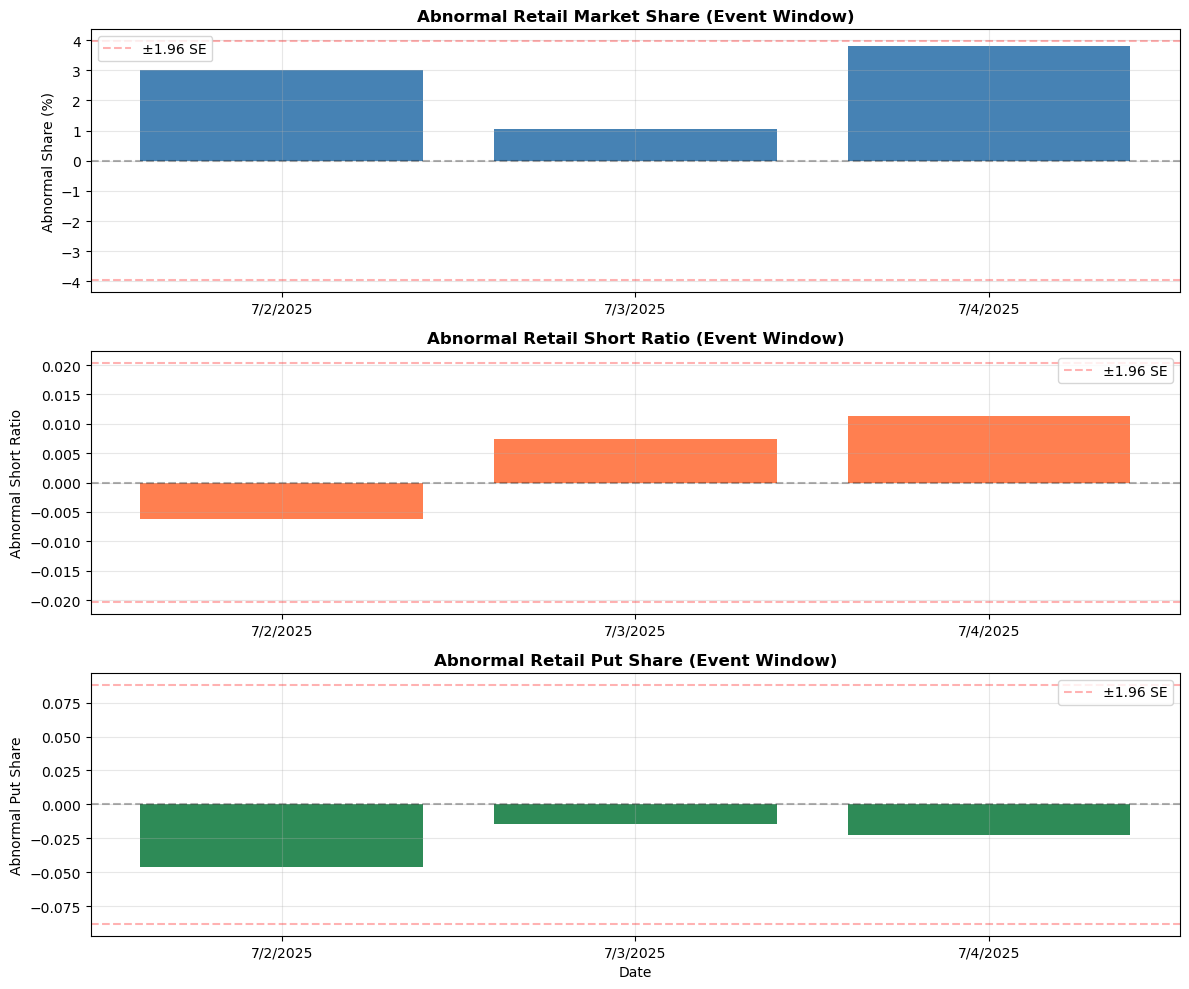

In [29]:
# Event Study (DEBUGGED)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler

# Ensure FII_Net_Position is present in data
data['FII_Net_Position'] = (
    data['FII_Future Index Long'] - data['FII_Future Index Short'] +
    data['FII_Option Index Call Long'] - data['FII_Option Index Call Short'] +
    data['FII_Option Index Put Short'] - data['FII_Option Index Put Long']
)

# Defining the event window

event_date = pd.to_datetime('2025-07-03')
event_window_start = event_date - timedelta(days=1)  # July 2, 2025
event_window_end = event_date + timedelta(days=1)    # July 4, 2025

# Creating the indicator variable 
data['Date_dt'] = pd.to_datetime(data['Date'])
data['Event_Window'] = (
    (data['Date_dt'] >= event_window_start) & 
    (data['Date_dt'] <= event_window_end)
).astype(int)

# Estimation period: All data EXCEPT event window (to avoid contamination)
estimation_data = data[data['Event_Window'] == 0].copy()
event_data = data[data['Event_Window'] == 1].copy()

# Using X1 (Institutional) as it was the best model

# Prepare estimation data
estimation_cols = ['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
                   'FII_Net_Position', 'Retail_Share', 'Retail_Short_Ratio', 
                   'Retail_Put_Share']

for col in estimation_cols:
    if col not in estimation_data.columns:
        raise Exception(f"Column '{col}' missing from estimation_data - check prior calculations.")

estimation_clean = estimation_data[estimation_cols].replace([np.inf, -np.inf], np.nan).dropna()

# Standardize
scaler_est = StandardScaler()
vars_to_scale_est = ['NSE VIX - India', 'Returns - BANK NIFTY INDEX', 'FII_Net_Position']
estimation_clean[vars_to_scale_est] = scaler_est.fit_transform(estimation_clean[vars_to_scale_est])

# Prepare X and y
X_estimation = estimation_clean[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX', 
                                  'FII_Net_Position']]
X_estimation = sm.add_constant(X_estimation)

# Fit models on estimation period only
model_retail_share_est = sm.OLS(estimation_clean['Retail_Share'], X_estimation).fit()
model_retail_short_est = sm.OLS(estimation_clean['Retail_Short_Ratio'], X_estimation).fit()
model_retail_put_est = sm.OLS(estimation_clean['Retail_Put_Share'], X_estimation).fit()

# Predicting values for the event window:
# Prepare event window data
event_cols = ['Date', 'DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX',
              'FII_Net_Position', 'Retail_Share', 'Retail_Short_Ratio', 'Retail_Put_Share']
event_clean = event_data[event_cols].replace([np.inf, -np.inf], np.nan).dropna()

# Scale using estimation period parameters
event_clean[vars_to_scale_est] = scaler_est.transform(event_clean[vars_to_scale_est])

# Prepare X for prediction
X_event = event_clean[['DayOfWeek', 'NSE VIX - India', 'Returns - BANK NIFTY INDEX', 
                       'FII_Net_Position']]
X_event = sm.add_constant(X_event)

# Generate predictions
event_clean['Predicted_Retail_Share'] = model_retail_share_est.predict(X_event)
event_clean['Predicted_Retail_Short'] = model_retail_short_est.predict(X_event)
event_clean['Predicted_Retail_Put'] = model_retail_put_est.predict(X_event)

# Calculate abnormal returns (actual - predicted)
event_clean['Abnormal_Retail_Share'] = event_clean['Retail_Share'] - event_clean['Predicted_Retail_Share']
event_clean['Abnormal_Retail_Short'] = event_clean['Retail_Short_Ratio'] - event_clean['Predicted_Retail_Short']
event_clean['Abnormal_Retail_Put'] = event_clean['Retail_Put_Share'] - event_clean['Predicted_Retail_Put']

results_summary = pd.DataFrame({
    'Date': event_clean['Date'],
    'Retail_Share_Actual': event_clean['Retail_Share'],
    'Retail_Share_Predicted': event_clean['Predicted_Retail_Share'],
    'Retail_Share_Abnormal': event_clean['Abnormal_Retail_Share'],
    'Retail_Short_Actual': event_clean['Retail_Short_Ratio'],
    'Retail_Short_Predicted': event_clean['Predicted_Retail_Short'],
    'Retail_Short_Abnormal': event_clean['Abnormal_Retail_Short'],
    'Retail_Put_Actual': event_clean['Retail_Put_Share'],
    'Retail_Put_Predicted': event_clean['Predicted_Retail_Put'],
    'Retail_Put_Abnormal': event_clean['Abnormal_Retail_Put']
})

# Testing the significance of abnormal behavior:
# Calculate standard errors from estimation period residuals
residuals_share = model_retail_share_est.resid
residuals_short = model_retail_short_est.resid
residuals_put = model_retail_put_est.resid

se_share = residuals_share.std()
se_short = residuals_short.std()
se_put = residuals_put.std()

# Calculate t-statistics for abnormal values
event_clean['t_stat_share'] = event_clean['Abnormal_Retail_Share'] / se_share
event_clean['t_stat_short'] = event_clean['Abnormal_Retail_Short'] / se_short
event_clean['t_stat_put'] = event_clean['Abnormal_Retail_Put'] / se_put

# Determine significance (|t| > 1.96 for 95% confidence)
event_clean['Sig_Share'] = (abs(event_clean['t_stat_share']) > 1.96).astype(str).replace({'True': 'YES', 'False': 'No'})
event_clean['Sig_Short'] = (abs(event_clean['t_stat_short']) > 1.96).astype(str).replace({'True': 'YES', 'False': 'No'})
event_clean['Sig_Put'] = (abs(event_clean['t_stat_put']) > 1.96).astype(str).replace({'True': 'YES', 'False': 'No'})

significance_summary = pd.DataFrame({
    'Date': event_clean['Date'],
    'Abnormal_Share': event_clean['Abnormal_Retail_Share'],
    't_stat_Share': event_clean['t_stat_share'],
    'Significant_Share': event_clean['Sig_Share'],
    'Abnormal_Short': event_clean['Abnormal_Retail_Short'],
    't_stat_Short': event_clean['t_stat_short'],
    'Significant_Short': event_clean['Sig_Short'],
    'Abnormal_Put': event_clean['Abnormal_Retail_Put'],
    't_stat_Put': event_clean['t_stat_put'],
    'Significant_Put': event_clean['Sig_Put']
})

# Cumulative Abnormal Behavior (CAR)
CAR_share = event_clean['Abnormal_Retail_Share'].sum()
CAR_short = event_clean['Abnormal_Retail_Short'].sum()
CAR_put = event_clean['Abnormal_Retail_Put'].sum()

# Standard error for CAR (sqrt(n) * SE)
n_days = len(event_clean)
se_CAR_share = se_share * np.sqrt(n_days)
se_CAR_short = se_short * np.sqrt(n_days)
se_CAR_put = se_put * np.sqrt(n_days)

# t-statistics for CAR
t_CAR_share = CAR_share / se_CAR_share
t_CAR_short = CAR_short / se_CAR_short
t_CAR_put = CAR_put / se_CAR_put

CAR_summary = pd.DataFrame({
    'Metric': ['Retail Share', 'Retail Short Ratio', 'Retail Put Share'],
    'CAR': [CAR_share, CAR_short, CAR_put],
    't_statistic': [t_CAR_share, t_CAR_short, t_CAR_put],
    'Significant_95%': [
        'YES' if abs(t_CAR_share) > 1.96 else 'No',
        'YES' if abs(t_CAR_short) > 1.96 else 'No',
        'YES' if abs(t_CAR_put) > 1.96 else 'No'
    ]
})

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Retail Share
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[0].axhline(y=1.96*se_share, color='red', linestyle='--', alpha=0.3, label='±1.96 SE')
axes[0].axhline(y=-1.96*se_share, color='red', linestyle='--', alpha=0.3)
axes[0].bar(event_clean['Date'], event_clean['Abnormal_Retail_Share'], color='steelblue')
axes[0].set_title('Abnormal Retail Market Share (Event Window)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Abnormal Share (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Retail Short Ratio
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1].axhline(y=1.96*se_short, color='red', linestyle='--', alpha=0.3, label='±1.96 SE')
axes[1].axhline(y=-1.96*se_short, color='red', linestyle='--', alpha=0.3)
axes[1].bar(event_clean['Date'], event_clean['Abnormal_Retail_Short'], color='coral')
axes[1].set_title('Abnormal Retail Short Ratio (Event Window)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Abnormal Short Ratio')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Retail Put Share
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[2].axhline(y=1.96*se_put, color='red', linestyle='--', alpha=0.3, label='±1.96 SE')
axes[2].axhline(y=-1.96*se_put, color='red', linestyle='--', alpha=0.3)
axes[2].bar(event_clean['Date'], event_clean['Abnormal_Retail_Put'], color='seagreen')
axes[2].set_title('Abnormal Retail Put Share (Event Window)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Abnormal Put Share')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('event_study_abnormal_behavior.png', dpi=300, bbox_inches='tight')
results_summary.to_csv('event_study_results.csv', index=False)
significance_summary.to_csv('event_study_significance.csv', index=False)
CAR_summary.to_csv('event_study_CAR.csv', index=False)
